# Geolocation Analysis of Transactions
Goal: Analyze spatial patterns of fraud transactions, detect randomness, and engineer useful location features


In [1]:
from pathlib import Path
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
FIGURES_DIR = Path("../reports/figures")
DATA_INTERIM_DIR = Path("../data/interim")

df = pd.read_parquet(DATA_INTERIM_DIR / "transactions.parquet")

In [3]:
df_location = pd.json_normalize(df['location'])
df = pd.concat([df.drop(columns=['location']), df_location], axis=1)

In [4]:
# Preserve original df with coordinates for visualization
df_with_geo = df.copy()

In [5]:
# --- 1. Validate geographic coordinate realism ---
print("Latitude range:", df["lat"].min(), "-", df["lat"].max())
print("Longitude range:", df["long"].min(), "-", df["long"].max())

Latitude range: 35.000013 - 69.999823
Longitude range: -9.999975 - 39.999761


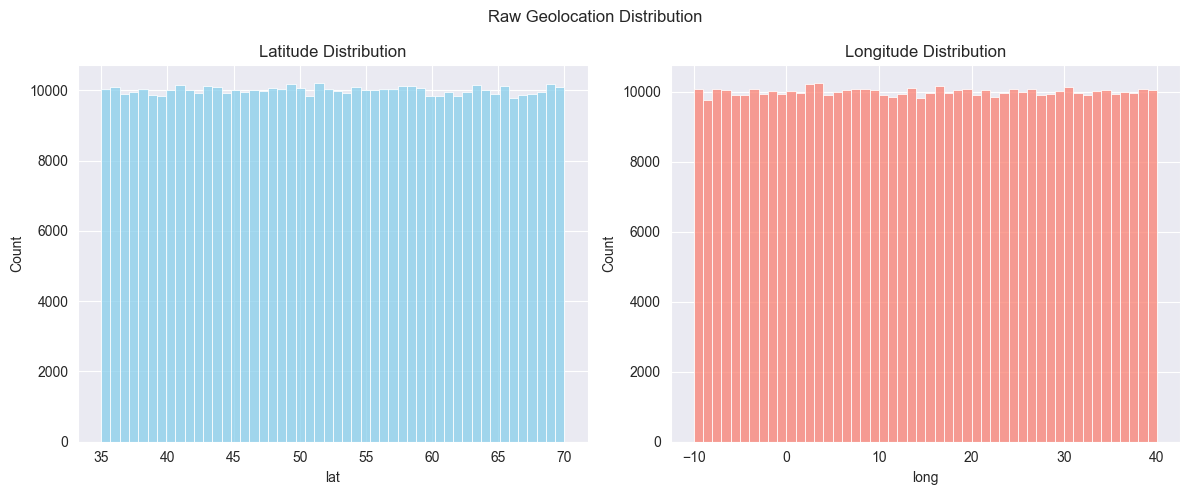

In [6]:
# --- 2. Histogram of locations ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df["lat"], bins=50, ax=axs[0], color="skyblue")
axs[0].set_title("Latitude Distribution")
sns.histplot(df["long"], bins=50, ax=axs[1], color="salmon")
axs[1].set_title("Longitude Distribution")
plt.suptitle("Raw Geolocation Distribution")
plt.tight_layout()
plt.show()

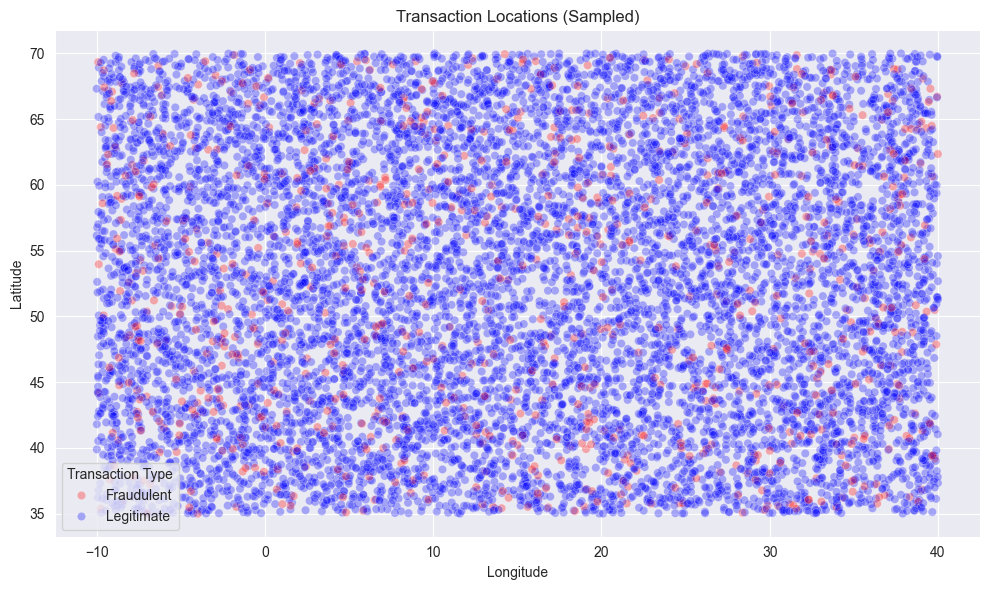

In [7]:
# --- 2. Visualize location scatter ---

label_map = {0: "Legitimate", 1: "Fraudulent"}
df_sampled = df.sample(10000, random_state=42).copy()
df_sampled["fraud_label"] = df_sampled["is_fraud"].map(label_map)

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=df_sampled,
    x="long", y="lat", hue="fraud_label",
    alpha=0.3, palette={"Legitimate": "blue", "Fraudulent": "red"},
    ax=ax
)

ax.set_title("Transaction Locations (Sampled)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(title="Transaction Type")

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/lat_long_scatter.png")
# plt.close()

plt.show()

In [8]:
# --- 3. Interactive map visualization ---
df_sample = df_with_geo[
    (df_with_geo["lat"].between(35, 70)) &
    (df_with_geo["long"].between(-10, 40))
].sample(5000, random_state=42)

df_sample["is_fraud_str"] = df_sample["is_fraud"].map({0: "Legit", 1: "Fraud"})

fig = px.scatter_map(
    df_sample,
    lat="lat",
    lon="long",
    color="is_fraud_str",
    color_discrete_map={
        "Legit": "rgba(0, 0, 255, 0.3)",
        "Fraud": "rgba(255, 0, 0, 0.7)"
    },
    hover_data=["is_fraud"],
    zoom=3,
    height=650
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox=dict(center={"lat": 52, "lon": 15}, zoom=3),
    legend=dict(
        title="Transaction Type",
        yanchor="top", y=0.99,
        xanchor="left", x=0.01,
        bgcolor="rgba(255,255,255,0.6)",
        bordercolor="gray",
        borderwidth=1
    ),
    margin={"r": 0, "t": 40, "l": 0, "b": 0},
    title={
        'text': "Interactive Map of Sampled Transactions (Fraud vs Legitimate)",
        'y': 0.95, 'x': 0.5,
        'xanchor': 'center', 'yanchor': 'top'
    }
)

fig.write_image(f"{FIGURES_DIR}/transaction_location_interactive_map.png")
fig.show()

In [9]:
# --- 4. Conclusion: Uniform spread implies synthetic/random values ---
# Transactions are evenly distributed across Europe, including oceans and low-population areas.
# This is a strong indicator that the coordinates are synthetic placeholders and not representative of real user or merchant locations.


In [10]:
# --- 5. Remove latitude and longitude from dataset ---
df = df.drop(columns=["lat", "long"])
print("Columns after dropping lat/long:", df.columns.tolist())


Columns after dropping lat/long: ['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'amount', 'channel', 'currency', 'device', 'payment_method', 'is_international', 'session_length_seconds', 'is_first_time_merchant', 'is_fraud']


In [11]:
# --- 6. Recommendation ---
# Based on distribution and absence of geospatial clustering, lat/long are excluded from further analysis.
# If real location data were available, feature engineering could include spatial bins, clustering, or anomaly scores.

df.to_parquet(f"{DATA_INTERIM_DIR}/transaction_locations_dropped.parquet")
